### intro text to be added

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from iso3166 import countries
import matplotlib.gridspec as gridspec
from matplotlib.colors import PowerNorm 

C:\Users\aalkhour\AppData\Local\Temp\ipykernel_14828\4185725569.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### 1) Data preparation

In [2]:
# Loading the Excel file into a Pandas DataFrame. 
# Data retreived from https://sciencebasedtargets.org/companies-taking-action on 06 June 2024
# The data are based on "Companies Taking Action" online dashboard.

df = pd.read_excel("companies-taking-action.xlsx")


In [3]:
# Rename columns "ISIN" and "LEI" 
column_renames = {
    'ISIN': '(ISIN) International Securities Identification Number',
    'LEI': '(LEI) Legal Entity Identifier'
}

for old_name, new_name in column_renames.items():
    if old_name in df.columns:
        df.rename(columns={old_name: new_name}, inplace=True)

In [4]:
# Renaming countries to match iso3166 library, for the maps code to work
# Note that this code may need to be updated if the relevant columns in SBTi dashboard or the iso3166 library are updated

name_mapping = {
    'United Kingdom': 'United Kingdom of Great Britain and Northern Ireland',
    'United Kingdom (UK)': 'United Kingdom of Great Britain and Northern Ireland',
    'United States of America (USA)': 'United States of America',
    'United Arab Emirates (UAE)': 'United Arab Emirates',
    'Turkey': 'Türkiye', 
    'South Korea': 'Korea, Republic of',
    'Vietnam': 'Viet Nam',
    'Russia': 'Russian Federation',
    'Czech Republic': 'Czechia',
    'Trinidad And Tobago': 'Trinidad and Tobago',
    'Bolivia': 'Bolivia, Plurinational State of',
    'Macau, Province of China': 'Macao',
    'Myanmar (Burma)': 'Myanmar',
    'Hong Kong, China': 'Hong Kong',
    'Tanzania': 'Tanzania, United Republic of',
}

# Update the 'Location' column based on the mapping dictionary
df['Location'] = df['Location'].replace(name_mapping)


In [5]:
# Create a df with ISO codes for the countries using iso3166 library
df_iso_codes = pd.DataFrame(countries, columns= ['name', 'alpha2', 'alpha3', 'numeric', 'apolitical_name'])


In [6]:
# Checking that all names match between the two dataframes 
df_iso_codes.name.unique()
df.Location.unique()
df.Location[~df.Location.isin(df_iso_codes.name)].unique()
# It should yield an empty array

array([], dtype=object)

In [7]:
# Merge the two DataFrames on the 'Location' column to add the ISO codes to the original DataFrame
df = pd.merge(df, df_iso_codes, left_on='Location', right_on='name', how='left')

In [8]:
# Test if the merge was successful
df[df['alpha3'].isnull()]['Location'].unique()
# It should yield an empty array

array([], dtype=object)

In [9]:
# Correcting the regional classification
region_mapping = {
    'United Kingdom of Great Britain and Northern Ireland': 'Europe', # Some entries have the UK in North America
    'United States of America': 'North America', # Some entries have the US in Europe
    'Türkiye': 'Europe', # Moving all Türkiye entries to Europe, currently some are in Asia 
}

# Loop through the dictionary to update the 'Region' column based on 'Location'
for location, region in region_mapping.items():
    df.loc[df['Location'] == location, 'Region'] = region

In [10]:
# Add a new column with Approved/Not Approved in line with SBTi classification
df['Approved'] = df['Near term - Target Classification'].apply(lambda x: 'Yes' if x in [
       '1.5°C', 
       '1.5°C/2°C',
       '1.5°C/Well-below 2°C',
       '2°C',
       '2°C/2°C',
       'Well-below 2°C',      
       'Well-below 2°C/2°C', 
       'Well-below 2°C/Well-below 2°C',] else 'No')

df.query('Approved == "Yes"')['Near term - Target Classification'].count()
# The count presented below (5510) is in line with the number of companies with approved targets on the SBTi website on the day of data retrieval (06 June 2024)  

5510

In [11]:
df['Near term - Target Classification'].value_counts()

Near term - Target Classification
1.5°C                            5044
Well-below 2°C                    406
2°C                                43
1.5°C/Well-below 2°C               10
Well-below 2°C/2°C                  4
Well-below 2°C/Well-below 2°C       1
2°C/2°C                             1
1.5°C/2°C                           1
Name: count, dtype: int64

In [12]:
# Simplify labels of target classifications
rename_dict = {
    'Well-below 2°C/Well-below 2°C': 'Well-below 2°C',
    '1.5°C/Well-below 2°C': '1.5°C or Well-below 2°C',
    'Well-below 2°C/2°C': 'Well-below 2°C or 2°C',
    '2°C/2°C': '2°C', 
    '1.5°C/2°C': '1.5°C or 2°C' 
}

# Apply the renaming
df['Near term - Target Classification'].replace(rename_dict, inplace=True)


C:\Users\aalkhour\AppData\Local\Temp\ipykernel_14828\1607807928.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Near term - Target Classification'].replace(rename_dict, inplace=True)


In [13]:
df['Near term - Target Classification'].value_counts()
# Note that categories merged

Near term - Target Classification
1.5°C                      5044
Well-below 2°C              407
2°C                          44
1.5°C or Well-below 2°C      10
Well-below 2°C or 2°C         4
1.5°C or 2°C                  1
Name: count, dtype: int64

In [14]:
# Rename the UK, Bolivia and Taiwan for plotting purposes
location_mapping = {
    'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom',
    'Bolivia, Plurinational State of': 'Bolivia',
    'Taiwan, Province of China': 'Taiwan'
}

# Loop through the dictionary to update the 'Location' column
for long_name, short_name in location_mapping.items():
    df.loc[df['Location'] == long_name, 'Location'] = short_name

### 2) Plot global map of SBTi Approved

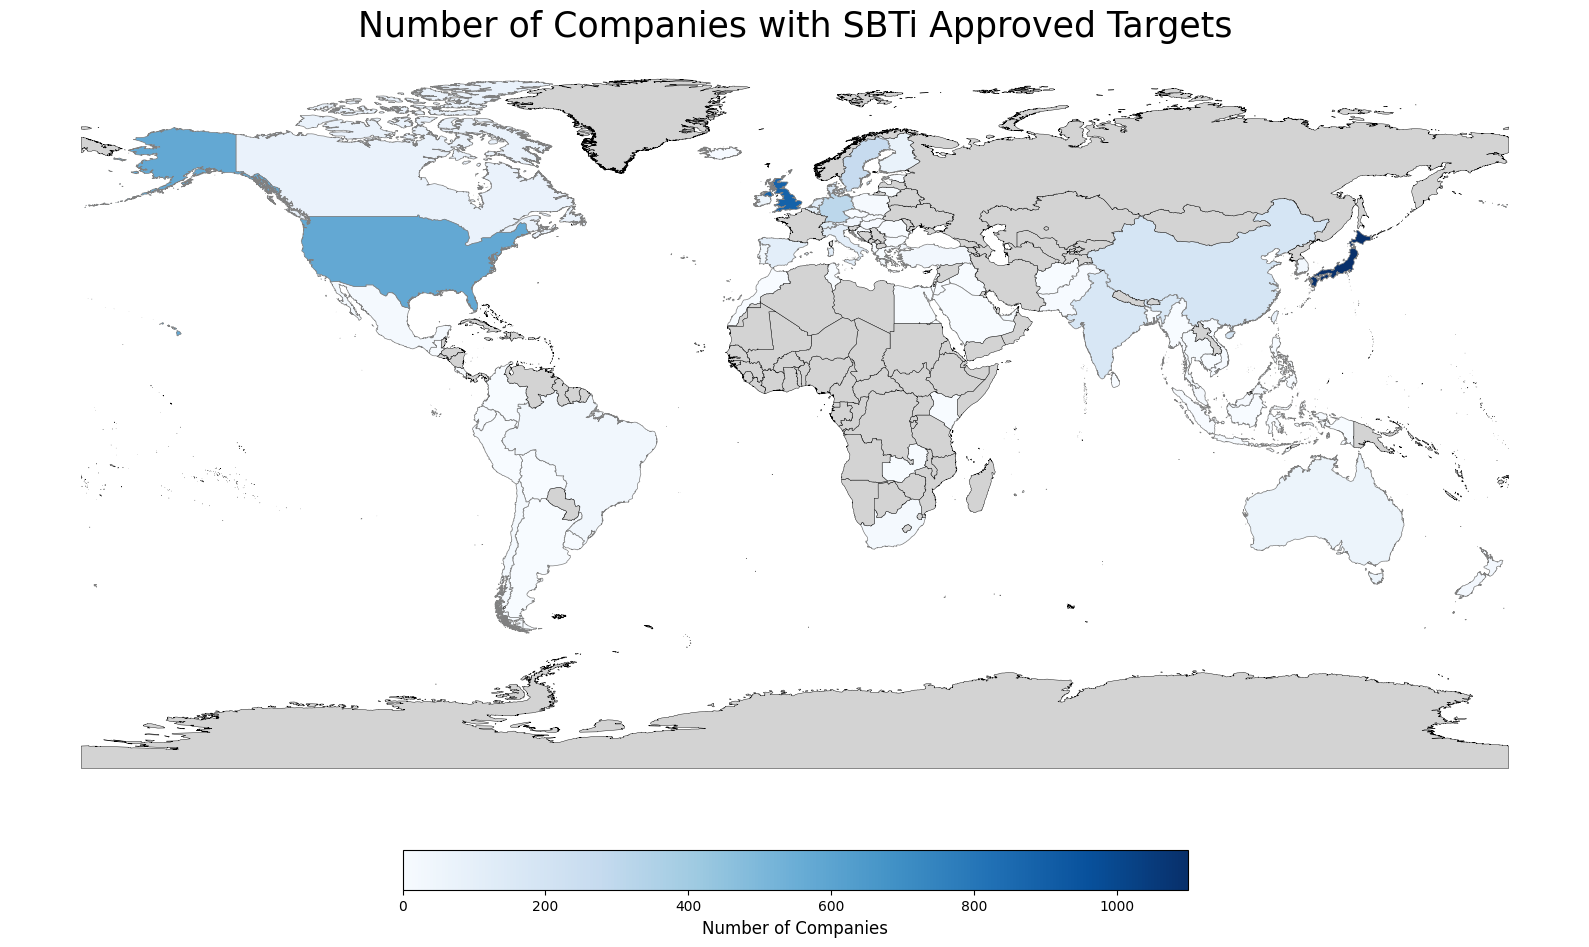

In [15]:
# ------------------- Generate a global map for SBTi Approved -------------------

# ------------------- 
# Prepare the data
# ------------------- 
# Data of the number of companies in each country with SBTi approved targets
grouped_by_region_location = df.query("Approved == 'Yes'").groupby(['Region', 'Location', 'alpha3']).size().reset_index(name='Count')

# ------------------- 
# Load the world map data
# ------------------- 
 
# Data downloaded from https://www.naturalearthdata.com/downloads/10m-cultural-vectors/,
# Under the "Countries" section, "Download countries" to download the shapefile. 
# Ensure that the path to the shapefile is correct.
world_map = gpd.read_file('shapefiles/ne_10m_admin_0_countries.shp')

# Merge the world map data with the grouped data
merged_data = world_map.merge(grouped_by_region_location, left_on='ISO_A3', right_on='alpha3', how='right')

# Select only the columns needed
merged_data = merged_data[['geometry', 'Count', 'ISO_A3', 'Region', 'Location']].drop_duplicates(subset=['Location'])

# ------------------- 
# Generat the map
# ------------------- 

# Generate a choropleth map
fig, ax = plt.subplots(figsize=(16, 10))

# Apply PowerNorm for non-linear normalization
norm = PowerNorm(gamma=1, vmin=grouped_by_region_location['Count'].min(), vmax=grouped_by_region_location['Count'].max())

# Plot countries with data and apply the norm
merged_data.plot(column='Count', cmap='Blues', linewidth=0.5, ax=ax, norm=norm, edgecolor='grey')

# Add shading to the countries with no data
world_map[~world_map['ISO_A3'].isin(merged_data['ISO_A3'])].plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.3)

# Turn off axis
ax.axis('off')

# Set title
ax.set_title('Number of Companies with SBTi Approved Targets', fontdict={'fontsize': '25', 'fontweight': '3'})

# Create colour bar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=norm)
sm._A = []  # Empty array for the data range

# Add the colour bar to the figure, place it below the map
cbar = fig.colorbar(sm, orientation='horizontal', shrink=0.5, ax=ax, pad=0.05)
cbar.set_label('Number of Companies', size=12)

# Make background colour white
fig.patch.set_facecolor('white')

# Save the figure as a PNG file
fig.savefig('SBTi_Approved_map.png', dpi=350)

# Display the figure
plt.tight_layout()
plt.show()

In [16]:
# Rename the UK, Bolivia and Taiwan for plotting purposes
location_mapping = {
    'United Kingdom': 'UK',
    'United States of America':'USA',
    'Korea, Republic of': 'South Korea',
    'United Arab Emirates': 'UAE'
}

# Loop through the dictionary to update the 'Location' column
for long_name, short_name in location_mapping.items():
    df.loc[df['Location'] == long_name, 'Location'] = short_name

C:\Users\aalkhour\AppData\Local\Temp\ipykernel_14828\3313933070.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(sorted_countries['Location'], rotation=90, fontsize=10)


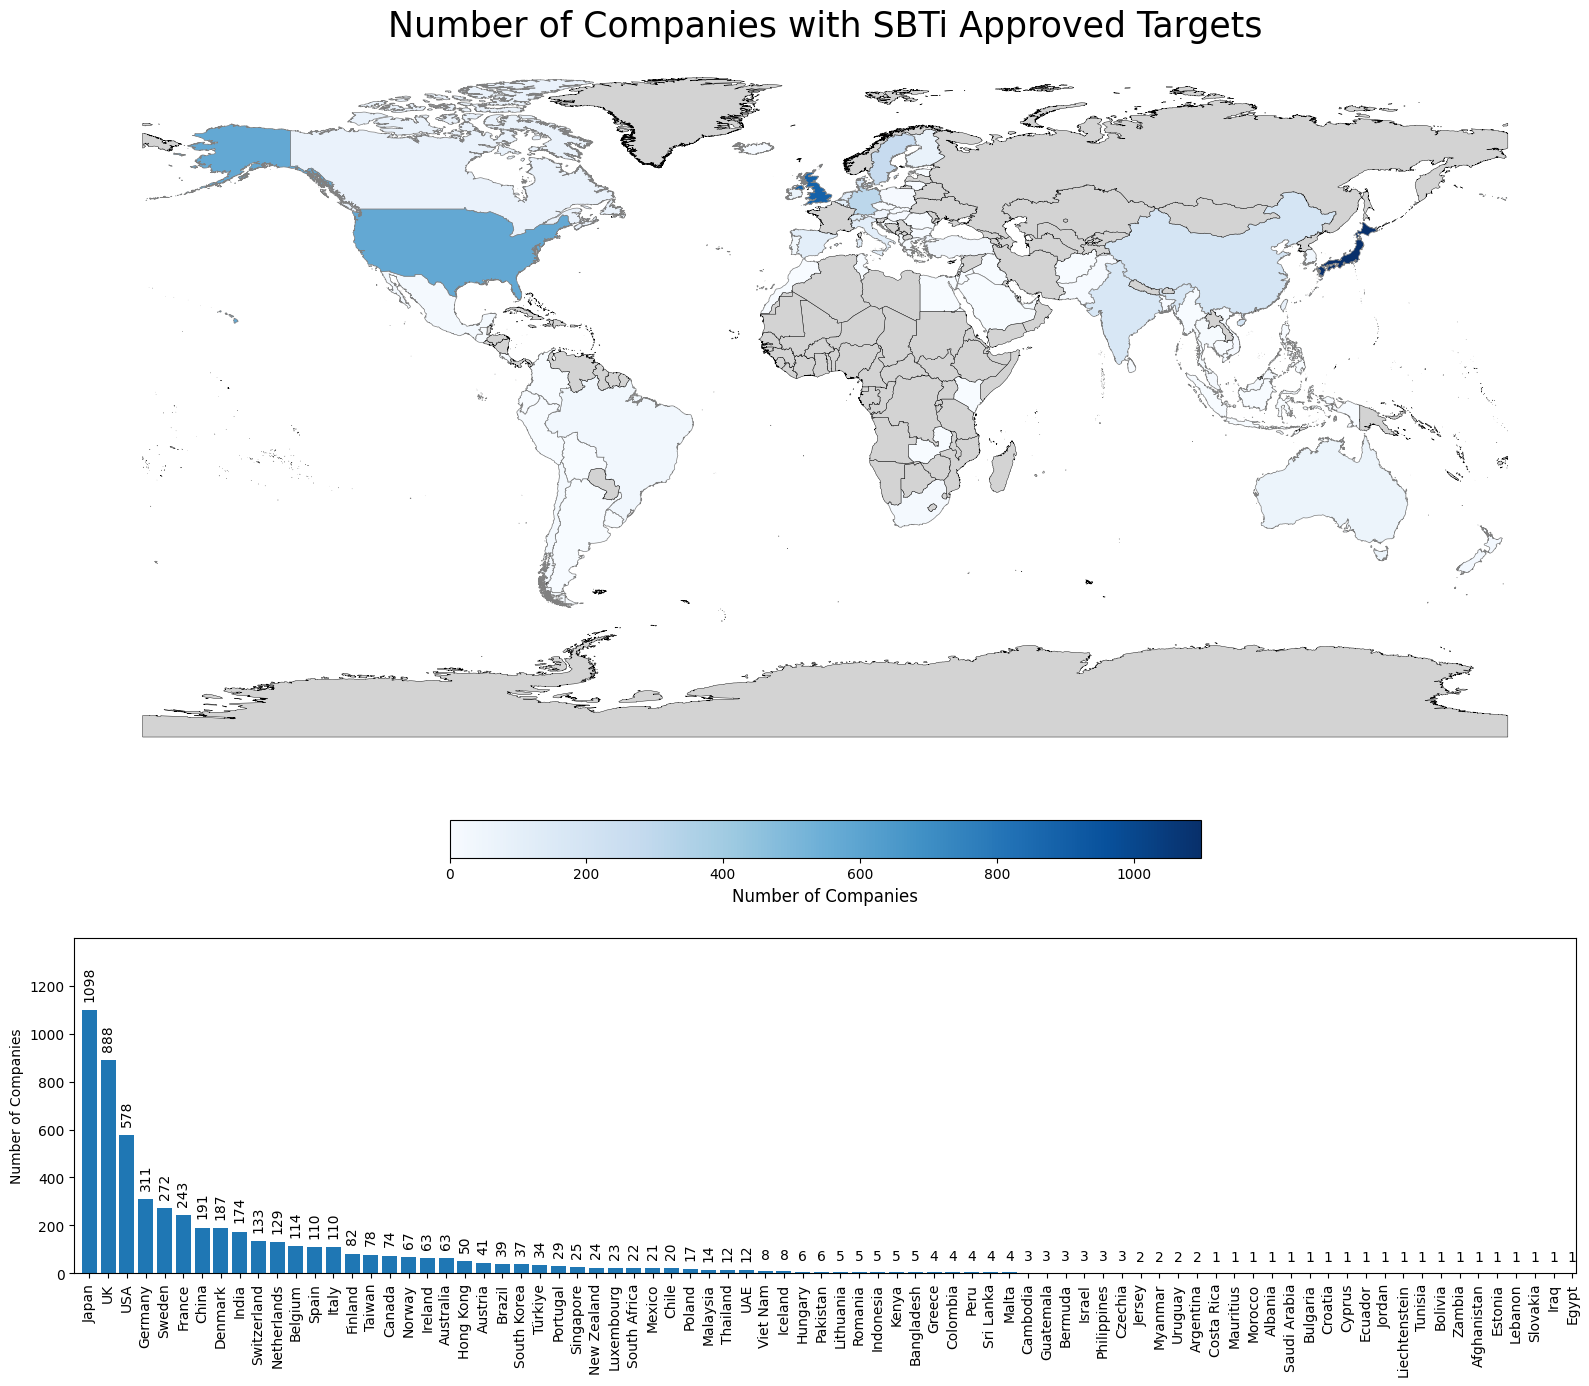

In [17]:
# ------------------- Generate a global map for SBTi Approved -------------------
# -------------------
# Prepare the data
# -------------------
# Data of the number of companies in each country with SBTi approved targets
grouped_by_region_location = df.query("Approved == 'Yes'").groupby(['Region', 'Location', 'alpha3']).size().reset_index(name='Count')

# -------------------
# Load the world map data
# -------------------
# Data downloaded from https://www.naturalearthdata.com/downloads/10m-cultural-vectors/, 
# Under the "Countries" section, "Download countries" to download the shapefile.
# Ensure that the path to the shapefile is correct.
world_map = gpd.read_file('shapefiles/ne_10m_admin_0_countries.shp')

# Merge the world map data with the grouped data
merged_data = world_map.merge(grouped_by_region_location, left_on='ISO_A3', right_on='alpha3', how='right')

# Select only the columns needed
merged_data = merged_data[['geometry', 'Count', 'ISO_A3', 'Region', 'Location']].drop_duplicates(subset=['Location'])

# -------------------
# Generate the map
# -------------------
fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

# Generate choropleth map
ax0 = plt.subplot(gs[0])
norm = PowerNorm(gamma=1, vmin=grouped_by_region_location['Count'].min(), vmax=grouped_by_region_location['Count'].max())
merged_data.plot(column='Count', cmap='Blues', linewidth=0.5, ax=ax0, norm=norm, edgecolor='grey')
world_map[~world_map['ISO_A3'].isin(merged_data['ISO_A3'])].plot(ax=ax0, color='lightgrey', edgecolor='black', linewidth=0.3)
ax0.axis('off')
ax0.set_title('Number of Companies with SBTi Approved Targets', fontdict={'fontsize': '25', 'fontweight': '3'})

ax0.set_position([0.0, 0.3, 1.0, 0.7]) 
# -------------------
# Generate the bar chart
# -------------------
ax1 = plt.subplot(gs[1])
sorted_countries = merged_data.sort_values(by='Count', ascending=False)
maximum_value = sorted_countries['Count'].max() + 300

ax1.bar(sorted_countries['Location'], sorted_countries['Count'])
for i, v in enumerate(sorted_countries['Count']):
    if i < 36: 
        ax1.text(i, v + 50, str(v), fontsize=10, ha='center', rotation =90)
    else: 
        ax1.text(i, v + 50, str(v), fontsize=10, ha='center')

ax1.set_ylim(0,maximum_value)
ax1.set_xticklabels(sorted_countries['Location'], rotation=90, fontsize=10)
ax1.set_ylabel('Number of Companies')
ax1.set_xlim(left=-0.8, right=len(sorted_countries['Location'])-0.8)

# -------------------
# Generate the colour bar
# -------------------
# Create colour bar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=norm)
sm._A = []  # Empty array for the data range

# Add the colour bar to the figure, place it below the map
cbar = fig.colorbar(sm, orientation='horizontal', shrink=0.5, ax=ax0, pad=0.05)
cbar.set_label('Number of Companies', size=12)

# Make background colour white
fig.patch.set_facecolor('white')

# -------------------
# Save the figure
# -------------------
fig.savefig('SBTi_Approved_map_with_bar_chart.png', dpi=350)

# -------------------
# Display the figure
# -------------------
plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()